In [37]:
import os
data_dir=r'C:\Users\박정은\Downloads\006975\datasets\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [40]:
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

In [41]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [42]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [43]:
lookback=1440
step=6
delay=144
batch_size=128
train_gen=generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen=generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,shuffle=True,step=step,batch_size=batch_size)
test_gen=generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,shuffle=True,step=step,batch_size=batch_size)
val_steps=(300000-200001-lookback)//batch_size
test_steps=(len(float_data)-300001-lookback)//batch_size

In [44]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 19s 39ms/step - loss: 1.1027 - val_loss: 0.4412
Epoch 2/20
500/500 [==============================] - 20s 39ms/step - loss: 0.3567 - val_loss: 0.3338
Epoch 3/20
500/500 [==============================] - 19s 37ms/step - loss: 0.2819 - val_loss: 0.3460
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2628 - val_loss: 0.3372
Epoch 5/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2529 - val_loss: 0.3002
Epoch 6/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2448 - val_loss: 0.3166
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2373 - val_loss: 0.2918
Epoch 8/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2309 - val_loss: 0.3411
Epoch 9/20
500/500 [==============================] - 20s 39ms/step - loss: 0.2269 - val_loss: 0.3004
Epoch 10/20
500/500 [==============================] - 19s 38ms/step - loss: 0.222

In [45]:
import matplotlib.pyplot as plt

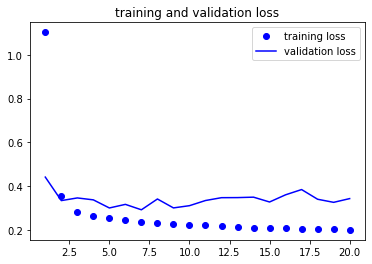

In [46]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

6.3.5. GRU

In [47]:
model=Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 143s 287ms/step - loss: 0.3013 - val_loss: 0.2943
Epoch 2/20
500/500 [==============================] - 144s 288ms/step - loss: 0.2824 - val_loss: 0.2576
Epoch 3/20
500/500 [==============================] - 141s 283ms/step - loss: 0.2773 - val_loss: 0.2545
Epoch 4/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2713 - val_loss: 0.2737
Epoch 5/20
500/500 [==============================] - 143s 287ms/step - loss: 0.2663 - val_loss: 0.3049
Epoch 6/20
500/500 [==============================] - 139s 277ms/step - loss: 0.2652 - val_loss: 0.2859
Epoch 7/20
500/500 [==============================] - 139s 278ms/step - loss: 0.2599 - val_loss: 0.2499
Epoch 8/20
500/500 [==============================] - 140s 279ms/step - loss: 0.2571 - val_loss: 0.2991
Epoch 9/20
500/500 [==============================] - 140s 280ms/step - loss: 0.2518 - val_loss: 0.2640
Epoch 10/20
500/500 [==============================] - 139s 277m

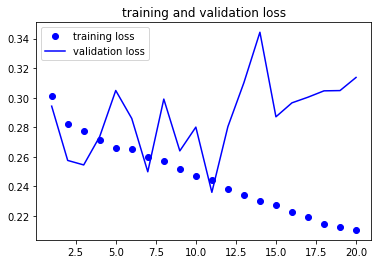

In [48]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

6.3.6 Dropout

In [49]:
model=Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 143s 286ms/step - loss: nan - val_loss: nan
Epoch 2/40
500/500 [==============================] - 143s 286ms/step - loss: nan - val_loss: nan
Epoch 3/40
500/500 [==============================] - 142s 283ms/step - loss: nan - val_loss: nan
Epoch 4/40
500/500 [==============================] - 142s 283ms/step - loss: nan - val_loss: nan
Epoch 5/40
500/500 [==============================] - 142s 284ms/step - loss: nan - val_loss: nan
Epoch 6/40
500/500 [==============================] - 142s 284ms/step - loss: nan - val_loss: nan
Epoch 7/40
500/500 [==============================] - 142s 284ms/step - loss: nan - val_loss: nan
Epoch 8/40
500/500 [==============================] - 142s 284ms/step - loss: nan - val_loss: nan
Epoch 9/40
500/500 [==============================] - 142s 283ms/step - loss: nan - val_loss: nan
Epoch 10/40
500/500 [==============================] - 141s 282ms/step - loss: nan - val_loss: nan
Epoch 11/40
500/500

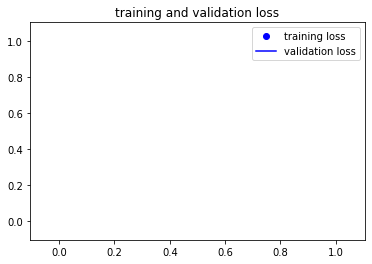

In [50]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

6.3.7. 순환층

In [ ]:
model=Sequential()
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None,float_data.shape[-1])))
model.add(layers.GRU(64,activation='relu',dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 407s 814ms/step - loss: nan - val_loss: nan
Epoch 2/40
500/500 [==============================] - 416s 833ms/step - loss: nan - val_loss: nan
Epoch 3/40
500/500 [==============================] - 403s 807ms/step - loss: nan - val_loss: nan
Epoch 4/40
500/500 [==============================] - 403s 805ms/step - loss: nan - val_loss: nan
Epoch 5/40
500/500 [==============================] - 401s 802ms/step - loss: nan - val_loss: nan
Epoch 6/40
500/500 [==============================] - 403s 806ms/step - loss: nan - val_loss: nan
Epoch 7/40
500/500 [==============================] - 401s 803ms/step - loss: nan - val_loss: nan
Epoch 8/40
500/500 [==============================] - 401s 803ms/step - loss: nan - val_loss: nan
Epoch 9/40
500/500 [==============================] - 402s 803ms/step - loss: nan - val_loss: nan
Epoch 10/40
500/500 [==============================] - 404s 809ms/step - loss: nan - val_loss: nan
Epoch 11/40
 86/500

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

6.3.8. 양방향 RNN

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features=10000
maxlen=500
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)
x_train=[x[x::-1] for x in x_train]
x_test=[x[x::-1]for x in x_test]
x_train=sequence.pad_sequences(x_train,maxlen=maxlen)
x_test=sequence.pad_sequences(x_test,maxlen=maxlen)

In [ ]:
model=Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizers='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)